## Visualization techniques for scalar fields in VTK + Python
## Goals 
* Inspect VTK Objects via the qtconsole for Jupyter (using the magic `%qtconsole`)
* Including a new filter, mapper, and actor to visualize the complete/partial mesh 
* Computing new data arrays using the `vtkCalculator()` 
* Performing data transformations: from rectilinear grid to unstructured grid and image data
* Data filtering
* Visualizing scalar fields using, points, surfaces, isosurfaces, and volume rendering 
    * Basics of transfer functions
    

# The code is in 05_Homework.py

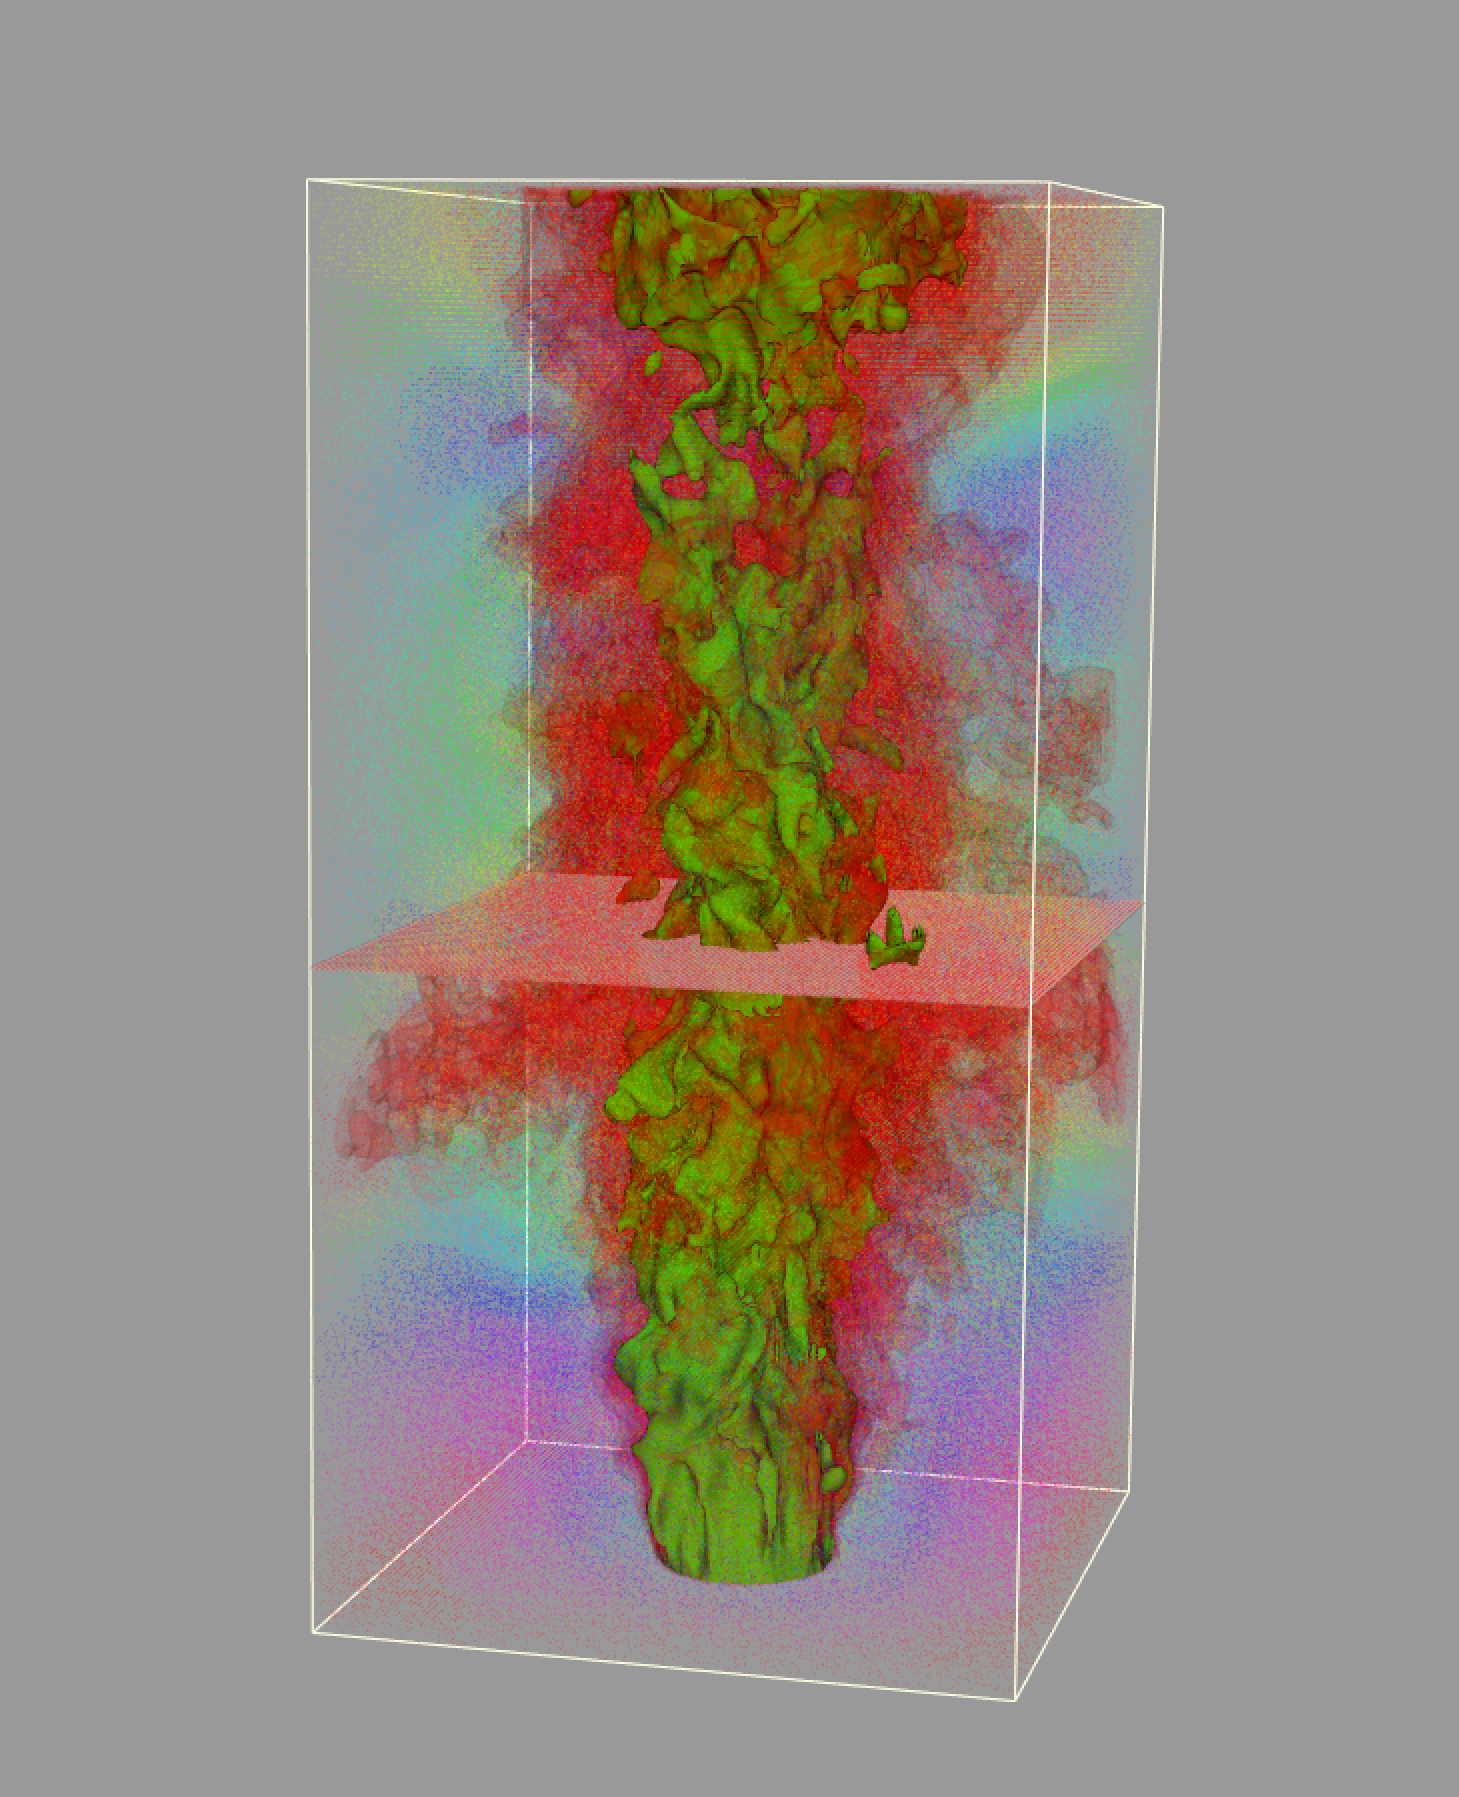

# Challenge 1: Adding a new Filter+Mapper+Actor to visualize the grid 
Try to find out how to visualize the mesh structure (grid). Take a look at [RectilinearGrid.py](http://www.vtk.org/Wiki/VTK/Examples/Python/RectilinearGrid/vtkRectilinearGrid) example from the VTK wiki.

In [1]:
import vtk
#help(vtk.vtkRectilinearGridReader())
%gui qt
rectGridReader = vtk.vtkRectilinearGridReader()
rectGridReader.SetFileName("data/jet4_0.500.vtk")
# do not forget to call "Update()" at the end of the reader
rectGridReader.Update()

In [82]:
rectGridOutline = vtk.vtkRectilinearGridOutlineFilter()
rectGridOutline.SetInputData(rectGridReader.GetOutput())

# New vtkRectilinearGridGeometryFilter() goes here:
plane = vtk.vtkRectilinearGridGeometryFilter()
plane.SetInputData(rectGridReader.GetOutput())
plane.SetExtent(0, 128,0,150 , 0, 128) 

rectGridOutlineMapper = vtk.vtkPolyDataMapper()
rectGridOutlineMapper.SetInputConnection(rectGridOutline.GetOutputPort())

rectGridGeomMapper = vtk.vtkPolyDataMapper()
rectGridGeomMapper.SetInputConnection(plane.GetOutputPort())

outlineActor = vtk.vtkActor()
outlineActor.SetMapper(rectGridOutlineMapper)
outlineActor.GetProperty().SetRepresentationToWireframe()
outlineActor.GetProperty().SetColor(1, 1, 0.9)

gridGeomActor = vtk.vtkActor()
gridGeomActor.SetMapper(rectGridGeomMapper)
#gridGeomActor.GetProperty().SetRepresentationToWireframe()
gridGeomActor.GetProperty().SetColor(0.9, 0.6, 0.6)
# Find out how to visualize this as a wireframe 
renderer = vtk.vtkRenderer()
renderer.SetBackground(1, 1, 1)
renderer.AddActor(outlineActor)
renderer.AddActor(gridGeomActor)
renderer.ResetCamera()

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetSize(700, 700)
renderer.GetActiveCamera().Elevation(60.0)
renderer.GetActiveCamera().Azimuth(30.0)
renderer.GetActiveCamera().Zoom(1.0)
renderWindow.Render()

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renderWindow)
iren.Start()
# Play with the options you get for setting up actor properties (color, opacity, etc.)


# Challenge 2: Using the vtkCalulator to compute the vector magnitude
As you should have noticed our data set has only one point data array named vectors. We need now to use this array to calculate the magnitude of the vectors at each point of the grid. We will do this by using the [vtk.vtkArrayCalculator()](http://www.vtk.org/doc/nightly/html/classvtkArrayCalculator.html).

In [16]:
#%qtconsole

In [7]:
magnitudeCalcFilter = vtk.vtkArrayCalculator()
magnitudeCalcFilter.SetInputConnection(rectGridReader.GetOutputPort())
magnitudeCalcFilter.AddVectorArrayName('vectors')
# Set up here the array that is going to be used for the computation ('vectors')
magnitudeCalcFilter.SetResultArrayName('magnitude')
magnitudeCalcFilter.SetFunction("mag(vectors)")
# Set up here the function that calculates the magnitude of a vector
magnitudeCalcFilter.Update()

#Inspect the output of the calculator using the IPython console to verify the result

# Challenge 3: Visualize the data set as colored points based on the "magnitude" value
Take a look at the [`subset`](http://www.vtk.org/doc/nightly/html/classvtkMaskPoints.html) object. What happens when you change the SetOnRadio parameter? Try out changing between different `RandomModeType` options. What does the `SetScalarModeToUsePointData()` function does?

In [28]:
#Extract the data from the result of the vtkCalculator
points = vtk.vtkPoints()
grid = magnitudeCalcFilter.GetOutput()
grid.GetPoints(points)
scalars = grid.GetPointData().GetArray('magnitude')

#Create an unstructured grid that will contain the points and scalars data
ugrid = vtk.vtkUnstructuredGrid()
ugrid.SetPoints(points)
ugrid.GetPointData().SetScalars(scalars)

#Populate the cells in the unstructured grid using the output of the vtkCalculator
for i in range (0, grid.GetNumberOfCells()):
    cell = grid.GetCell(i)
    ugrid.InsertNextCell(cell.GetCellType(), cell.GetPointIds())

In [67]:
lut2 = vtk.vtkLookupTable()
lut2.SetNumberOfColors(10)
lut2.SetHueRange(1, 0)
lut2.SetVectorModeToMagnitude()
lut2.Build()
#There are too many points, let's filter the points
subset = vtk.vtkMaskPoints()
subset.SetOnRatio(10)
subset.RandomModeOn()
subset.SetInputData(ugrid)

#Make a vtkPolyData with a vertex on each point.
pointsGlyph = vtk.vtkVertexGlyphFilter()
pointsGlyph.SetInputConnection(subset.GetOutputPort())
#pointsGlyph.SetInputData(ugrid)
pointsGlyph.Update()

plane = vtk.vtkRectilinearGridGeometryFilter()
plane.SetInputData(pointsGlyph.GetOutput())
plane.SetExtent(0, 128,0,150 , 0, 128) 
plane.Update()

pointsMapper = vtk.vtkPolyDataMapper()
pointsMapper.SetInputConnection(pointsGlyph.GetOutputPort())
pointsMapper.SetLookupTable(lut2)
pointsMapper.SetScalarModeToUsePointData()

pointsActor = vtk.vtkActor()
pointsActor.SetMapper(pointsMapper)
pointsActor.GetProperty().SetOpacity(1)

# Challenge 4: Visualize the data set as isosurfaces based on the "magnitude" value
Go to the documentation of vtkContourFilter and explain what does the GenerateValues() do?  Inspect the scalarRange of the magnitude array. What happens when you change these values in the function? 

In [71]:
scalarRange = ugrid.GetPointData().GetScalars().GetRange()

isoFilter = vtk.vtkContourFilter()
isoFilter.SetInputData(ugrid)
isoFilter.GenerateValues(3, scalarRange)

isoMapper = vtk.vtkPolyDataMapper()
isoMapper.SetInputConnection(isoFilter.GetOutputPort())
isoMapper.SetLookupTable(lut)

isoActor = vtk.vtkActor()
isoActor.SetMapper(isoMapper)
isoActor.GetProperty().SetOpacity(1)

scalarRange = ugrid.GetPointData().GetScalars().GetRange()

isoFilter2 = vtk.vtkContourFilter()
isoFilter2.SetInputData(ugrid)
isoFilter2.GenerateValues(10, scalarRange)

isoMapper2 = vtk.vtkPolyDataMapper()
isoMapper2.SetInputConnection(isoFilter2.GetOutputPort())
isoMapper2.SetLookupTable(lut2)

isoActor2 = vtk.vtkActor()
isoActor2.SetMapper(isoMapper2)
isoActor2.GetProperty().SetOpacity(0.1)

# An alternative to define colormaps 

In [72]:
lut = vtk.vtkLookupTable()
lut.SetNumberOfColors(256)
lut.SetHueRange(0.667, 0.3)
lut.SetVectorModeToMagnitude()
lut.Build()

hh = vtk.vtkHedgeHog()
hh.SetInputConnection(subset.GetOutputPort())
hh.SetScaleFactor(0.001)

hhm = vtk.vtkPolyDataMapper()
hhm.SetInputConnection(hh.GetOutputPort())
hhm.SetLookupTable(lut)
hhm.SetScalarVisibility(True)
hhm.SetScalarModeToUsePointFieldData()
hhm.SelectColorArray('vectors')
hhm.SetScalarRange((grid.GetPointData().GetVectors().GetRange(-1)))

hhActor = vtk.vtkActor()
hhActor.SetMapper(hhm)

### Renderer, render window, and interactor 

In [87]:
#Option 1: Default vtk render window
renderer = vtk.vtkRenderer()
renderer.SetBackground(0.6, 0.6, 0.6)
renderer.AddActor(outlineActor)
renderer.AddActor(isoActor)
renderer.AddActor(isoActor2)
#renderer.AddActor(gridGeomActor)
renderer.AddActor(pointsActor)
renderer.ResetCamera()

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)
renderWindow.SetSize(2000, 2000)
renderWindow.Render()

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renderWindow)
iren.Start()